# Key Observation-Extending IO with IO Size

0         HUNTER
1       HUNTER-J
2           PMFS
3           NOVA
4     NOVA-RELAX
5    SplitFS-FIO
6       EXT4-DAX
7        XFS-DAX
Name: file_system, dtype: object


/usr/local/lib64/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


(0.5, -0.3626351745033597)


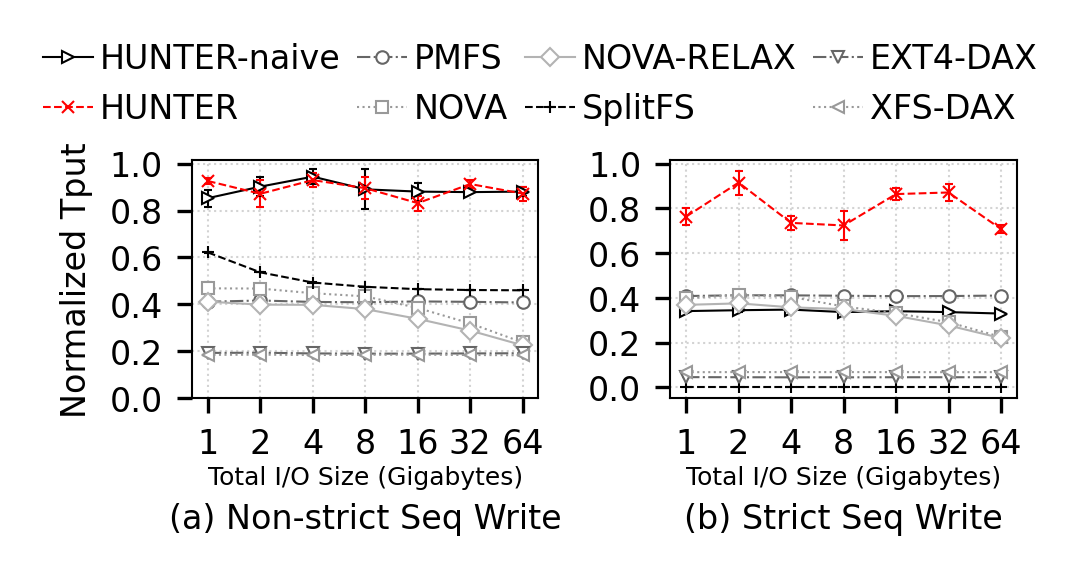

In [3]:
# ipython -c "%run plot.ipynb"

from math import ceil
import matplotlib
from matplotlib import gridspec
from matplotlib.axes import Axes
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
plt.rcParams.update(plt.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = False
%matplotlib inline
style.use('grayscale')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["hatch.color"] = "black"
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Data Preprocessing
# with open("./avg-test-result-in-paper", "r") as f:
with open("./performance-comparison-table", "r") as f:
    df_no_strict = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')
with open("./performance-comparison-table-fsync", "r") as f:
    df_fsync = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

df = df_no_strict
df.drop(df[df['file_system'] == "PMM"].index, inplace=True)
# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(4)))
fig.patch.set_facecolor('white')

line_width = 0.5
# colors = ["#2b2d42", "#8d99ae", "#1a535c", "#ef233c", "#4ecdc4"]
marks = [">", "x", "o", "s", "D", "+", "v", "<", "d", "^", "p", "h", "H", "X", "*", "|", "_"]
# seven line types
line_types = ["-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":"]
subtitles = ["(a) Non-strict Seq Write", "(b) Strict Seq Write", ]
fss = df['file_system'].drop_duplicates().reset_index().drop(columns=['index'])['file_system']
print(fss)
ops = ["seq-write", "seq-write", ]
fsize = [1024, 2048, 4096, 8192, 16384, 32768, 65536]

def zoom_in(axins, x, ys, zone_left, zone_right):
    # 坐标轴的扩展比例（根据实际数据调整）
    x_ratio = 0.1 # x轴显示范围的扩展比例
    y_ratio = 0.5 # y轴显示范围的扩展比例

    # X轴的显示范围
    xlim0 = x[zone_left]-(x[zone_right]-x[zone_left])*x_ratio
    xlim1 = x[zone_right]+(x[zone_right]-x[zone_left])*x_ratio

    stack = []
    for y in ys:
        stack.append(y[zone_left:zone_right])
    y = np.hstack(stack)
    ylim0 = np.min(y)-(np.max(y)-np.min(y))*y_ratio
    ylim1 = np.max(y)+(np.max(y)-np.min(y))*y_ratio

    # 调整子坐标系的显示范围
    axins.set_xlim(xlim0, xlim1)
    axins.set_ylim(ylim0, ylim1)


def add_explanation_and_title(fig, ax: Axes, exp, title, title_pad=10, title_fontsize=8, exp_fontsize=6):
    lable_pad = title_pad
    ax.set_xlabel(title, fontsize=title_fontsize, labelpad=lable_pad) 
    return [exp, title, title_pad, title_fontsize, exp_fontsize]
    
def adjust_explanation(fig, axes, context):
    exp, title, title_pad, title_fontsize, exp_fontsize = context
    
    # plt.tight_layout()
    # fig.savefig("./temp.pdf", bbox_inches='tight', pad_inches=0)
    fig.savefig("./temp.pdf", bbox_inches='tight', pad_inches=0)
    # for ax in fig.axes:
        # plt.tight_layout()
        # Get the first xtick label
    midpoint = (0.5, 0.5)
    for idx, ax in enumerate(axes):
        xtick_label = ax.get_xticklabels()[0]
        label_bbox1 = xtick_label.get_window_extent()
        # print(label_bbox1)
        figure_pos1 = label_bbox1.transformed(ax.transAxes.inverted())
        
        # Get the xlabel object
        xlable = ax.xaxis.label
        label_bbox2 = xlable.get_window_extent()
        # print(label_bbox2)
        figure_pos2 = label_bbox2.transformed(ax.transAxes.inverted())
        midpoint = (0.5, (figure_pos1.y0 + figure_pos2.y1) / 2 + 0.08)
        
    print(midpoint)
    for idx, ax in enumerate(axes):
        explanation = ax.text(midpoint[0], midpoint[1], exp, ha='center', fontsize=exp_fontsize, transform=ax.transAxes)   

        # fig.savefig("./temp" + str(idx) + ".pdf", bbox_inches='tight', pad_inches=0)
        # # adjust midpoint
        # explanation_bbox = explanation.get_window_extent().transformed(ax.transAxes.inverted())
        # height = explanation_bbox.height
        # midpoint = (midpoint[0], midpoint[1] + height)
        # explanation.set_position(midpoint)

# gs0 = gridspec.GridSpec(2, 2, figure=fig, wspace=0.3, hspace=0.6)
lines = []
cmap = "tab10"
context = ""
axes = []
for op_idx, op in enumerate(ops):
    subfig = plt.subplot(1, 2, op_idx + 1)
    df = df_no_strict if op_idx == 0 else df_fsync
        
    # subfig = plt.subplot(gs0[op_idx])
    for idx, fs in enumerate(fss):
        if fs == "PMM":
            continue
        if op_idx == 1 and fs == "HUNTER":
            fs = "HUNTER-SYNC"
        # line = plt.errorbar(fsize, df[(df['file_system'] == fs) & (df['ops'] == op)]['bandwidth(MiB/s)'] / 2259.2, yerr=df[(df['file_system'] == fs) & (df['ops'] == op)]['std-bandwidth(MiB/s)'] / 2259.2, color=plt.get_cmap(cmap)(idx), markerfacecolor=plt.get_cmap(cmap)(idx), linewidth=line_width,label=fs, marker=marks[idx], markersize=3, markeredgewidth=0.5, linestyle=line_types[idx],capsize=1, elinewidth=0.5)
        if fs == "HUNTER-J":
            line = plt.errorbar(fsize, df[(df['file_system'] == fs) & (df['ops'] == op)]['bandwidth(MiB/s)'] / 2259.2, yerr=df[(df['file_system'] == fs) & (df['ops'] == op)]['std-bandwidth(MiB/s)'] / 2259.2,  linewidth=line_width,label=fs, color="red", markerfacecolor="red", marker=marks[idx], markersize=3, markeredgewidth=0.5, linestyle=line_types[idx],capsize=1, elinewidth=0.5)
        else:
            line = plt.errorbar(fsize, df[(df['file_system'] == fs) & (df['ops'] == op)]['bandwidth(MiB/s)'] / 2259.2, yerr=df[(df['file_system'] == fs) & (df['ops'] == op)]['std-bandwidth(MiB/s)'] / 2259.2,  linewidth=line_width,label=fs, markerfacecolor="white", marker=marks[idx], markersize=3, markeredgewidth=0.5, linestyle=line_types[idx],capsize=1, elinewidth=0.5)
        
        lines.append(line)
    ax = fig.gca()
    lw = 0.5
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(lw)
    ax.set_xscale('log', base=2)
    plt.xticks([1024, 2048, 4096, 8192, 16384, 32768, 65536], fontsize=8)
    ax.set_xticklabels(['1', '2', '4', '8', '16', '32', '64'])
    # plt.tick_params(bottom=False, top=False, left=False, right=False)

    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
    context = add_explanation_and_title(fig, ax, "Total I/O Size (Gigabytes)", subtitles[op_idx], title_pad=10, title_fontsize=8, exp_fontsize=6)
    axes.append(ax)
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=8)
    if (op_idx == 0):
        plt.ylabel('Normalized Tput', fontsize=8)

fss.replace("SplitFS-FIO", "SplitFS", inplace=True)
fss.replace("HUNTER", "HUNTER-naive", inplace=True)
fss.replace("HUNTER-J", "HUNTER", inplace=True)

# get handles
handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
handles = [h[0] for h in handles]
# use them in the legend
# ax1.legend(handles, labels, loc='upper left',numpoints=1)

fig.legend(handles, fss, loc='center', bbox_to_anchor=(0.5, 1.05), ncol=4, fontsize=8, frameon=False, columnspacing=0.5, handletextpad=0.2, borderaxespad=0.1, handlelength=1.5)
# fig.text(0.03, 0.55, "Throughput (GiB/s)", va='center', rotation='vertical', fontsize=8)
plt.tight_layout()
adjust_explanation(fig, axes, context)
plt.savefig("./FIG-Motivation.pdf", bbox_inches='tight', pad_inches=0)


# FIG-IO

/usr/local/lib64/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


(0.5, -0.4581211845346475)


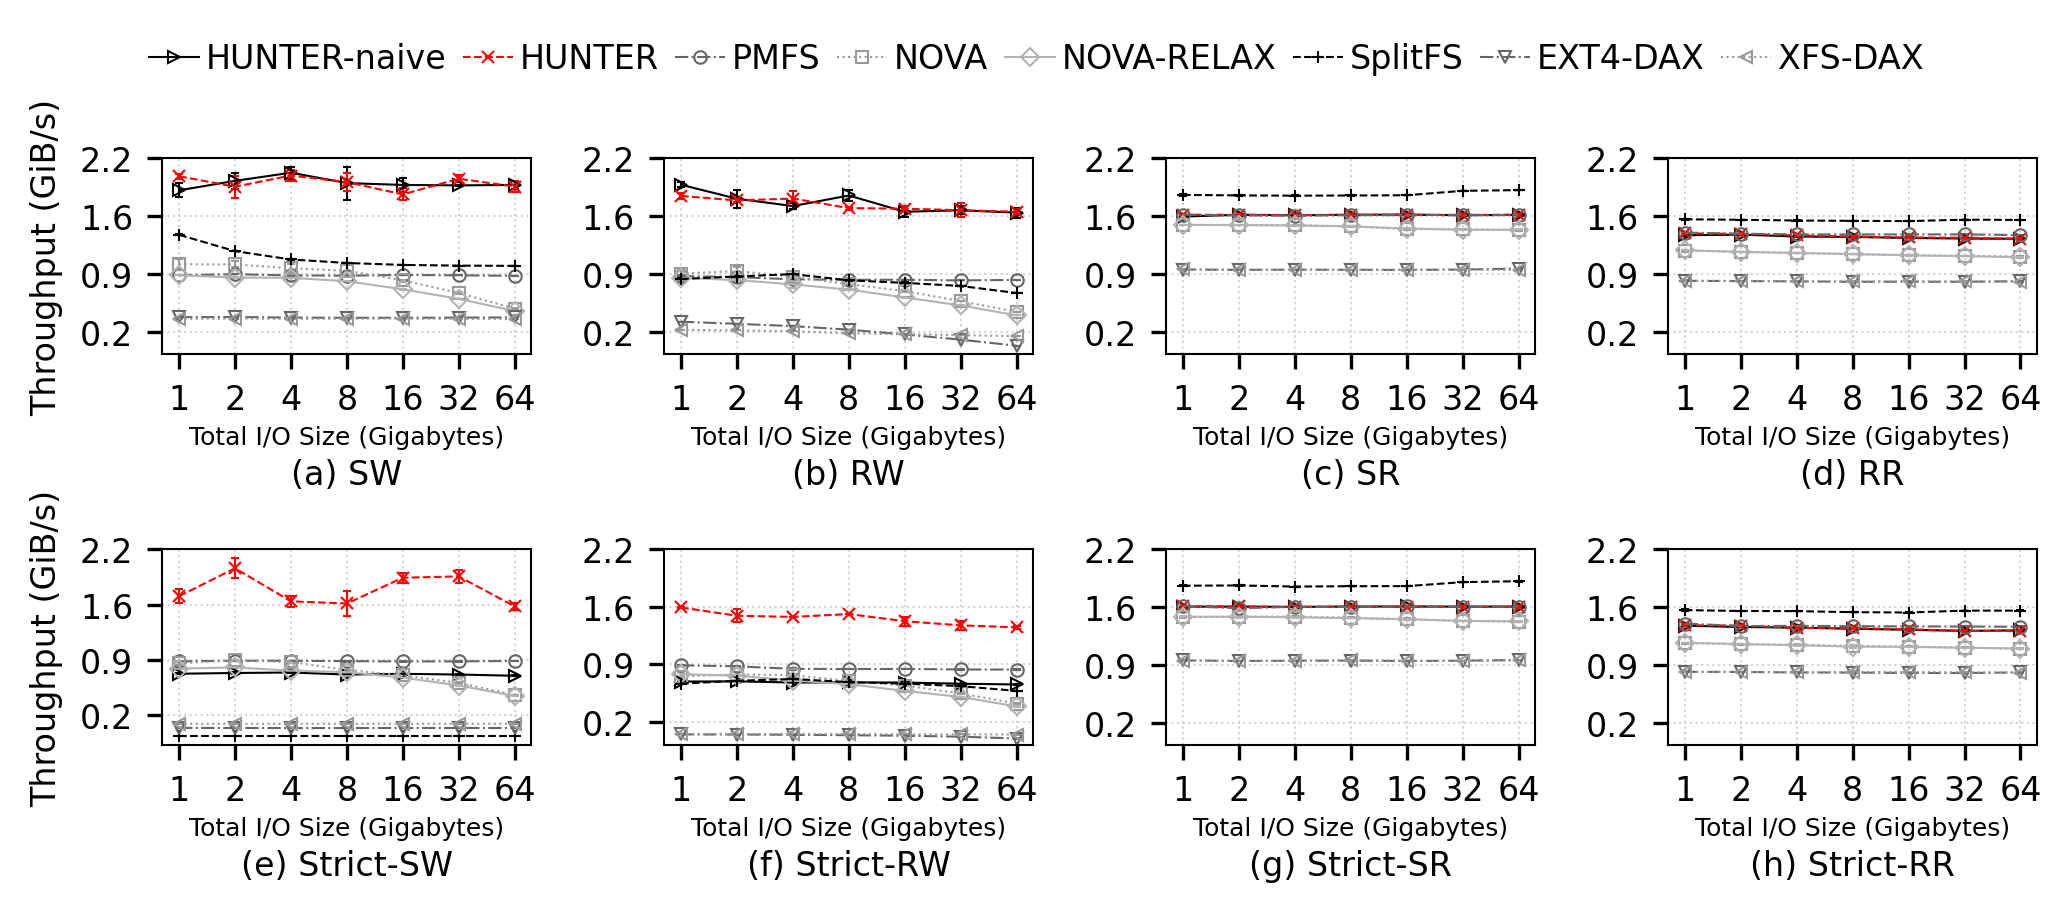

In [4]:
# ipython -c "%run plot.ipynb"

import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
# matplotlib style settings
plt.rcParams.update(plt.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = False
%matplotlib inline
style.use('grayscale')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["hatch.color"] = "black"
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Data Preprocessing
# with open("./avg-test-result-in-paper", "r") as f:
with open("./performance-comparison-table", "r") as f:
    df_no_strict = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')
with open("./performance-comparison-table-fsync", "r") as f:
    df_fsync = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

df = df_no_strict
df.drop(df[df['file_system'] == "PMM"].index, inplace=True)
# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(DOUBLE_COL_WIDTH), cm_to_inch(7)))
fig.patch.set_facecolor('white')

line_width = 0.5
# colors = ["#2b2d42", "#8d99ae", "#1a535c", "#ef233c", "#4ecdc4"]
marks = [">", "x", "o", "s", "D", "+", "v", "<", "d", "^", "p", "h", "H", "X", "*", "|", "_"]
# seven line types
line_types = ["-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":"]
subtitles = ["(a) SW", "(b) RW", "(c) SR", "(d) RR", "(e) Strict-SW", "(f) Strict-RW", "(g) Strict-SR", "(h) Strict-RR"]
fss = df['file_system'].drop_duplicates().reset_index().drop(columns=['index'])['file_system']
ops = ["seq-write", "rnd-write", "seq-read", "rnd-read"]
fsize = [1024, 2048, 4096, 8192, 16384, 32768, 65536]

def zoom_in(axins, x, ys, zone_left, zone_right):
    # 坐标轴的扩展比例（根据实际数据调整）
    x_ratio = 0.1 # x轴显示范围的扩展比例
    y_ratio = 0.5 # y轴显示范围的扩展比例

    # X轴的显示范围
    xlim0 = x[zone_left]-(x[zone_right]-x[zone_left])*x_ratio
    xlim1 = x[zone_right]+(x[zone_right]-x[zone_left])*x_ratio

    stack = []
    for y in ys:
        stack.append(y[zone_left:zone_right])
    y = np.hstack(stack)
    ylim0 = np.min(y)-(np.max(y)-np.min(y))*y_ratio
    ylim1 = np.max(y)+(np.max(y)-np.min(y))*y_ratio

    # 调整子坐标系的显示范围
    axins.set_xlim(xlim0, xlim1)
    axins.set_ylim(ylim0, ylim1)

# gs0 = gridspec.GridSpec(2, 2, figure=fig, wspace=0.3, hspace=0.6)
context = ""
axes = []
lines = []
cmap = "tab10"

for i in [0, 1]:
    for op_idx, op in enumerate(ops):
        subfig = plt.subplot(2, 4, 4 * i + op_idx + 1)
        df = df_no_strict if i == 0 else df_fsync
        # subfig = plt.subplot(gs0[op_idx])
        for idx, fs in enumerate(fss):
            if fs == "PMM":
                continue
            if fs == "HUNTER" and i == 1:
                fs = "HUNTER-SYNC"
            if fs == "HUNTER-J":
                line = plt.errorbar(fsize, df[(df['file_system'] == fs) & (df['ops'] == op)]['bandwidth(MiB/s)'] / 1024, yerr=df[(df['file_system'] == fs) & (df['ops'] == op)]['std-bandwidth(MiB/s)'] / 1024,  linewidth=line_width,label=fs, color="red", markerfacecolor="red", marker=marks[idx], markersize=3, markeredgewidth=0.5, linestyle=line_types[idx],capsize=1, elinewidth=0.5)
            else:
                line = plt.errorbar(fsize, df[(df['file_system'] == fs) & (df['ops'] == op)]['bandwidth(MiB/s)'] / 1024, yerr=df[(df['file_system'] == fs) & (df['ops'] == op)]['std-bandwidth(MiB/s)'] / 1024,  linewidth=line_width,label=fs, markerfacecolor="none", marker=marks[idx], markersize=3, markeredgewidth=0.5, linestyle=line_types[idx],capsize=1, elinewidth=0.5)
            
                
            # plt.scatter(num_jobs, df[(df['file_system'] == fs) & (df['ops'] == op)]['bandwidth(MiB/s)'] / 1024, color=plt.get_cmap(cmap)(idx), s=0.1)
            lines.append(line)
        ax = fig.gca()
        lw = 0.5
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(lw)
        ax.set_xscale('log', base=2)
        plt.xticks(fsize, labels=[1, 2, 4, 8, 16, 32, 64], fontsize=8)
        # plt.tick_params(bottom=False, top=False, left=False, right=False)
        
        ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
        # subfig.text(0.5, -0.4, "Total I/O Size (Gigabytes)", ha='center', va='center', fontsize=6, transform=subfig.transAxes)
        # plt.xlabel(subtitles[op_idx], fontsize=8, labelpad=10) 
        # plt.title(subtitles[op_idx], fontsize=8, loc='center')
        context = add_explanation_and_title(fig, ax, "Total I/O Size (Gigabytes)", subtitles[4 * i + op_idx])
        axes.append(ax)


        plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=8)
        if ((i == 0 and op_idx == 0) or (i == 1 and op_idx == 0)):
            plt.ylabel('Throughput (GiB/s)', fontsize=8)
        if op_idx == 0 or op_idx == 1:
            plt.yticks(np.linspace(0.25, 2.25, 4), fontsize=8)
        else:
            plt.yticks(np.linspace(0.25, 2.25, 4), fontsize=8)


fss.replace("SplitFS-FIO", "SplitFS", inplace=True)
fss.replace("HUNTER", "HUNTER-naive", inplace=True)
fss.replace("HUNTER-J", "HUNTER", inplace=True)
handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
handles = [h[0] for h in handles]
# use them in the legend
# ax1.legend(handles, labels, loc='upper left',numpoints=1)

fig.legend(handles, fss, loc='center', bbox_to_anchor=(0.5, 1.05), ncol=8, fontsize=8, frameon=False, columnspacing=0.5, handletextpad=0.2, borderaxespad=0.1, handlelength=1.5)
# fig.text(0.03, 0.55, "Throughput (GiB/s)", va='center', rotation='vertical', fontsize=8)
plt.tight_layout()
adjust_explanation(fig, axes, context)
# gs0.tight_layout(fig)
plt.savefig("./FIG-IO.pdf", bbox_inches='tight', pad_inches=0)


# Only SR and RR

/usr/local/lib64/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


(0.5, -0.45914973810753384)


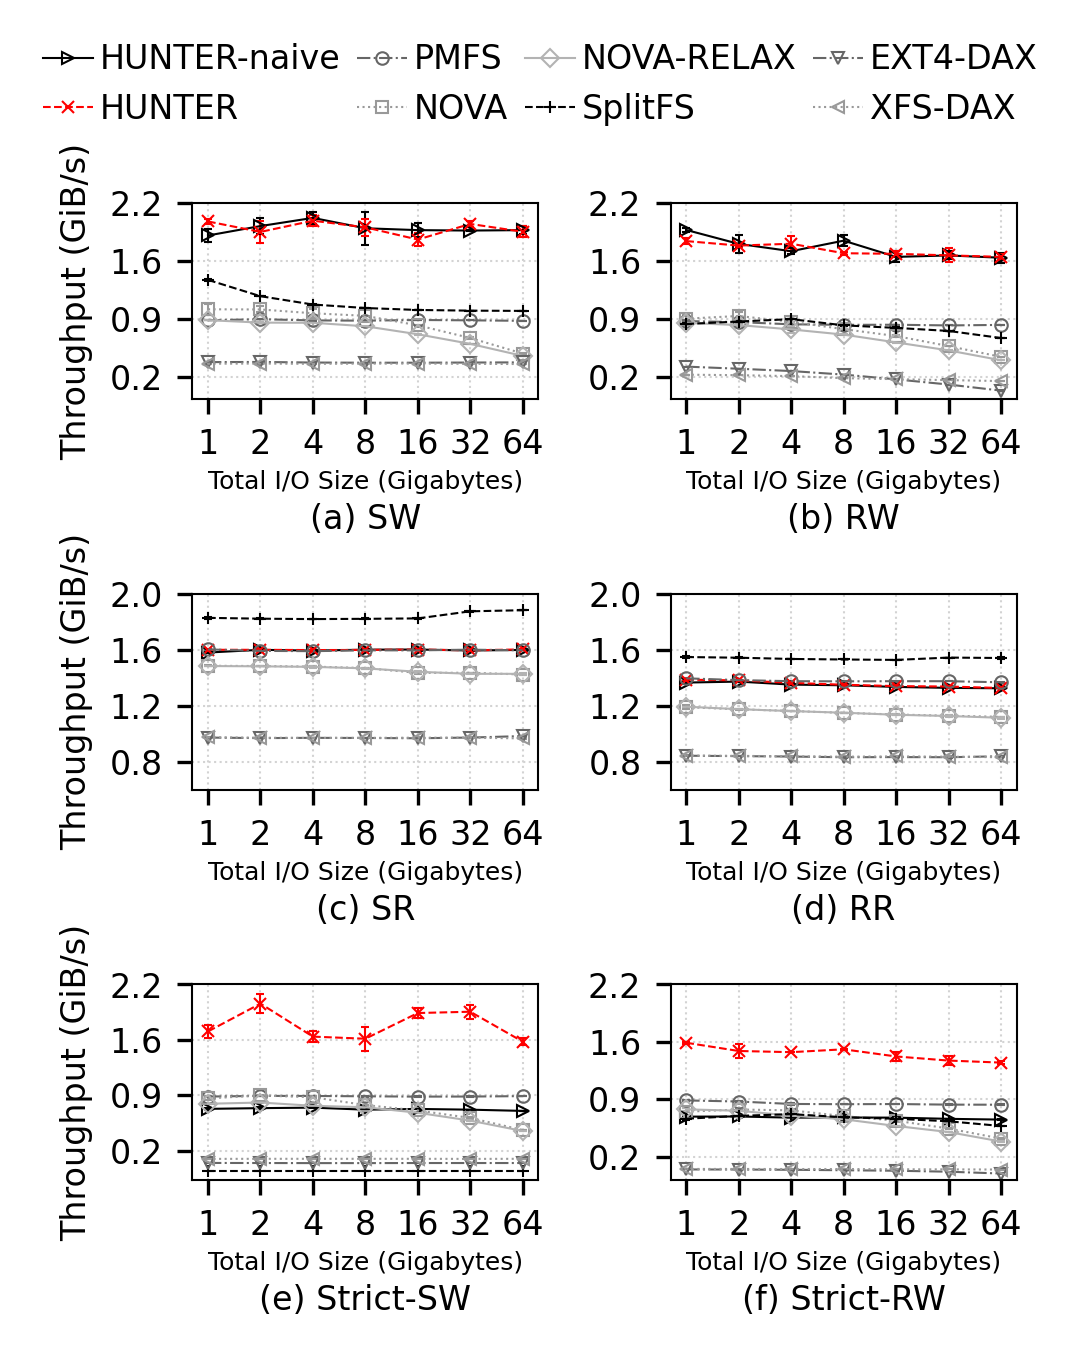

In [34]:
# ipython -c "%run plot.ipynb"

import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
# matplotlib style settings
plt.rcParams.update(plt.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = False
%matplotlib inline
style.use('grayscale')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["hatch.color"] = "black"
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Data Preprocessing
# with open("./avg-test-result-in-paper", "r") as f:
with open("./performance-comparison-table", "r") as f:
    df_no_strict = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')
with open("./performance-comparison-table-fsync", "r") as f:
    df_fsync = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

df = df_no_strict
df.drop(df[df['file_system'] == "PMM"].index, inplace=True)
# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(10.3)))
fig.patch.set_facecolor('white')

line_width = 0.5
# colors = ["#2b2d42", "#8d99ae", "#1a535c", "#ef233c", "#4ecdc4"]
marks = [">", "x", "o", "s", "D", "+", "v", "<", "d", "^", "p", "h", "H", "X", "*", "|", "_"]
# seven line types
line_types = ["-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":"]
subtitles = ["(a) SW", "(b) RW", "(c) SR", "(d) RR", "(e) Strict-SW", "(f) Strict-RW"]
fss = df['file_system'].drop_duplicates().reset_index().drop(columns=['index'])['file_system']
ops = ["seq-write", "rnd-write", "seq-read", "rnd-read"]
fsize = [1024, 2048, 4096, 8192, 16384, 32768, 65536]

def zoom_in(axins, x, ys, zone_left, zone_right):
    # 坐标轴的扩展比例（根据实际数据调整）
    x_ratio = 0.1 # x轴显示范围的扩展比例
    y_ratio = 0.5 # y轴显示范围的扩展比例

    # X轴的显示范围
    xlim0 = x[zone_left]-(x[zone_right]-x[zone_left])*x_ratio
    xlim1 = x[zone_right]+(x[zone_right]-x[zone_left])*x_ratio

    stack = []
    for y in ys:
        stack.append(y[zone_left:zone_right])
    y = np.hstack(stack)
    ylim0 = np.min(y)-(np.max(y)-np.min(y))*y_ratio
    ylim1 = np.max(y)+(np.max(y)-np.min(y))*y_ratio

    # 调整子坐标系的显示范围
    axins.set_xlim(xlim0, xlim1)
    axins.set_ylim(ylim0, ylim1)

# gs0 = gridspec.GridSpec(2, 2, figure=fig, wspace=0.3, hspace=0.6)
context = ""
axes = []
lines = []
cmap = "tab10"

for i in [0, 1]:
    for op_idx, op in enumerate(ops):
        if 4 * i + op_idx + 1 > 6:
            continue
        subfig = plt.subplot(3, 2, 4 * i + op_idx + 1)
        df = df_no_strict if i == 0 else df_fsync
        # subfig = plt.subplot(gs0[op_idx])
        for idx, fs in enumerate(fss):
            if fs == "PMM":
                continue
            if fs == "HUNTER" and i == 1:
                fs = "HUNTER-SYNC"
            if fs == "HUNTER-J":
                line = plt.errorbar(fsize, df[(df['file_system'] == fs) & (df['ops'] == op)]['bandwidth(MiB/s)'] / 1024, yerr=df[(df['file_system'] == fs) & (df['ops'] == op)]['std-bandwidth(MiB/s)'] / 1024,  linewidth=line_width,label=fs, color="red", markerfacecolor="red", marker=marks[idx], markersize=3, markeredgewidth=0.5, linestyle=line_types[idx],capsize=1, elinewidth=0.5)
            else:
                line = plt.errorbar(fsize, df[(df['file_system'] == fs) & (df['ops'] == op)]['bandwidth(MiB/s)'] / 1024, yerr=df[(df['file_system'] == fs) & (df['ops'] == op)]['std-bandwidth(MiB/s)'] / 1024,  linewidth=line_width,label=fs, markerfacecolor="none", marker=marks[idx], markersize=3, markeredgewidth=0.5, linestyle=line_types[idx],capsize=1, elinewidth=0.5)
            
                
            # plt.scatter(num_jobs, df[(df['file_system'] == fs) & (df['ops'] == op)]['bandwidth(MiB/s)'] / 1024, color=plt.get_cmap(cmap)(idx), s=0.1)
            lines.append(line)
        ax = fig.gca()
        lw = 0.5
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(lw)
        ax.set_xscale('log', base=2)
        plt.xticks(fsize, labels=[1, 2, 4, 8, 16, 32, 64], fontsize=8)
        # plt.tick_params(bottom=False, top=False, left=False, right=False)
        
        ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
        # subfig.text(0.5, -0.4, "Total I/O Size (Gigabytes)", ha='center', va='center', fontsize=6, transform=subfig.transAxes)
        # plt.xlabel(subtitles[op_idx], fontsize=8, labelpad=10) 
        # plt.title(subtitles[op_idx], fontsize=8, loc='center')
        context = add_explanation_and_title(fig, ax, "Total I/O Size (Gigabytes)", subtitles[4 * i + op_idx])
        axes.append(ax)

        plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=8)
        if ((4 * i + op_idx + 1) in [1, 3, 5]):
            plt.ylabel('Throughput (GiB/s)', fontsize=8)
        
        if op == "rnd-read" or op == "seq-read":
            plt.ylim(0.6, 2)
            plt.yticks(np.linspace(0.8, 2, 4), fontsize=8)
        else:          
            plt.yticks(np.linspace(0.25, 2.25, 4), fontsize=8)


fss.replace("SplitFS-FIO", "SplitFS", inplace=True)
fss.replace("HUNTER", "HUNTER-naive", inplace=True)
fss.replace("HUNTER-J", "HUNTER", inplace=True)
handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
handles = [h[0] for h in handles]
# use them in the legend
# ax1.legend(handles, labels, loc='upper left',numpoints=1)

fig.legend(handles, fss, loc='center', bbox_to_anchor=(0.5, 1.05), ncol=4, fontsize=8, frameon=False, columnspacing=0.5, handletextpad=0.2, borderaxespad=0.1, handlelength=1.5)
# fig.text(0.03, 0.55, "Throughput (GiB/s)", va='center', rotation='vertical', fontsize=8)
plt.tight_layout()
adjust_explanation(fig, axes, context)
# gs0.tight_layout(fig)
plt.savefig("./FIG-IO.pdf", bbox_inches='tight', pad_inches=0)
